In [1]:
import scanpy as sc, numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [2]:
adata = sc.read_h5ad("bipolar_raw.h5ad")

Conclusion: Choose type 5a cone bipolar cell because it offers a balance between class imbalance and cluster size

### Training starts!

In [3]:
sub_adata = adata[adata.obs["cell_type"] == "type 5a cone bipolar cell"].copy()

In [4]:
sub_adata

AnnData object with n_obs × n_vars = 18842 × 32034
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'pANN', 'sampleid', 'age', 'gender', 'reference', 'accession', 'sample_note', 'subclass_label', 'author_cell_type', 'development_stage_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'donor_id', 'organism_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'tissue_type', 'library_platform', 'cell_type_ontology_term_id', 'is_primary_data', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'gene_symbols', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
    uns: 'citation', 'default_embedding', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_pca', 'X_scVI', 'X_umap'

In [5]:
age_counts = sub_adata.obs["age"].value_counts()

In [6]:
bullies = ["W8", "P17", "W4"] #They are bullies because they overshadow others :(

In [7]:
mean_other = int(age_counts.drop(bullies, errors="ignore").mean())
# Step 4: Downsample W8 and P17 to mean_other
keep_indices = []
for age, count in age_counts.items():
    idx = sub_adata.obs[sub_adata.obs["age"] == age].index
    if age in bullies and count > mean_other:
        sampled = np.random.choice(idx, mean_other, replace=False)
    else:
        sampled = idx
    keep_indices.extend(sampled)

# Step 5: Subset to balanced data
balanced_adata = sub_adata[keep_indices].copy()

In [8]:
# Step 6: Prepare data
X = balanced_adata.X.toarray() if not isinstance(balanced_adata.X, np.ndarray) else balanced_adata.X
y = balanced_adata.obs["age"].astype(str)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Step 7: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, stratify=y_encoded, test_size=0.2, random_state=42)

# Step 8: Train XGBoost (GPU)
clf = XGBClassifier(
    tree_method='hist',
    device = 'cuda',
    eval_metric='mlogloss'
)
clf.fit(X_train, y_train)

# Step 9: Evaluate
y_pred = clf.predict(X_test)
y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)
print(classification_report(y_test_labels, y_pred_labels))

sh: 1: nvidia-smi: not found


              precision    recall  f1-score   support

          M4       0.79      0.97      0.87        31
         P14       1.00      0.85      0.92        13
         P17       0.93      1.00      0.96        13
        P180       0.93      0.83      0.88        30
         P40       0.73      0.92      0.81        12
         P90       0.83      0.94      0.88        16
         W11       0.33      0.60      0.43         5
         W12       1.00      0.33      0.50         3
          W7       0.75      0.60      0.67         5
          W8       0.43      0.23      0.30        13
          W9       0.00      0.00      0.00         3

    accuracy                           0.80       144
   macro avg       0.70      0.66      0.66       144
weighted avg       0.79      0.80      0.78       144



/home/mr_wick/miniconda3/envs/omics_python/lib/python3.13/site-packages/xgboost/core.py:729: UserWarning: [15:35:53] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/home/mr_wick/miniconda3/envs/omics_python/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mr_wick/miniconda3/envs/omics_python/lib/python3.13/site-packages/sk

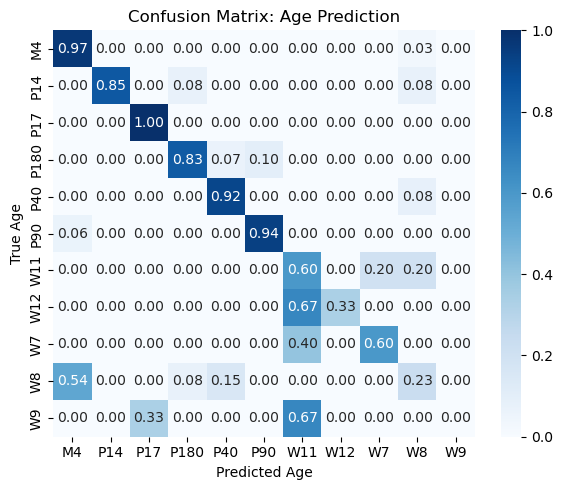

In [9]:
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=np.unique(y_test_labels), normalize = "true")

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=np.unique(y_test_labels),
            yticklabels=np.unique(y_test_labels))
plt.xlabel("Predicted Age")
plt.ylabel("True Age")
plt.title("Confusion Matrix: Age Prediction")
plt.tight_layout()
plt.show()